# Part 2: Training an ML Model

Part 2 trained a logistic regression ML model on the disaster dataset and explored the model.

In this part we have accomplished the following:

- Created a training function and stored models
- Viewed plot artifacts such as confusion matrix and correlations

## Step 1: Write an ML model in MLRun

In [1]:
from os import path
import mlrun

Continue working with the Laviosa project by calling the `project` and `user_project` parameters to the same values that we used in the call to this method in the Part 1.

In [2]:
# Set the base project name
project_name_base = 'getting-started-tutorial'
# Initialize the MLRun environment and save the project name and artifacts path
project_name, artifact_path = mlrun.set_environment(project=project_name_base,
                                                    user_project=True)

In [3]:
# mlrun: start-code

In [4]:
from sklearn import linear_model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from cloudpickle import dumps
import pandas as pd

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.mlutils.data import get_sample
from mlrun.mlutils.plots import eval_model_v2

In [5]:
def train_iris(context: MLClientCtx,
               dataset: DataItem,
               label_column: str = "labels"):

    raw, labels, header = get_sample(dataset, sample=-1, label=label_column)
    
    # Basic scikit-learn Iris data-set SVM model
    X_train, X_test, y_train, y_test = train_test_split(
        raw, labels, test_size=0.2, random_state=42)
    
    context.log_dataset('train_set', 
                        df=pd.concat([X_train, y_train.to_frame()], axis=1),
                        format='csv', index=False, 
                        artifact_path=context.artifact_subpath('data'))

    context.log_dataset('test_set', 
                        df=pd.concat([X_test, y_test.to_frame()], axis=1),
                        format='csv', index=False, 
                        labels={"data-type": "held-out"},
                        artifact_path=context.artifact_subpath('data'))
    
    model = linear_model.LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    
    # Evaluate model results and get the evaluation metrics
    eval_metrics = eval_model_v2(context, X_test, y_test, model)
    
    # Log model
    context.log_model("model",
                      body=dumps(model),
                      artifact_path=context.artifact_subpath("models"),
                      extra_data=eval_metrics, 
                      model_file="model.pkl",
                      metrics=context.results,
                      labels={"class": "sklearn.linear_model.LogisticRegression"})

In [6]:
# mlrun: end-code

In [7]:
# convert to a MLRun function 
train_iris_func = mlrun.code_to_function(name='train_iris',
                                         handler='train_iris',
                                         kind='job',
                                         image='mlrun/mlrun')

In [8]:
from mlrun.platforms import auto_mount
train_iris_func = train_iris_func.apply(auto_mount())

## Step 2: Running the Function on a Cluster

Use the following code to run your function on a cluster.

In [9]:
# calling dataset that is prepared from part 1
dataset = f'store://{project_name}/prep_data_cleaned_data'
dataset

'store://getting-started-tutorial-jovyan/prep_data_cleaned_data'

In [10]:
train_run = train_iris_func.run(inputs={'dataset': dataset},
                                params={'label_column': 'label'})

> 2021-07-06 21:11:43,039 [info] starting run train-iris-train_iris uid=bb63688a79984e71a7bfa22ce59f0493 DB=http://mlrun-api:8080
> 2021-07-06 21:11:43,181 [info] Job is running in the background, pod: train-iris-train-iris-z7dm7
> 2021-07-06 21:11:50,288 [info] run executed, status=completed
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-jovyan,...e59f0493,0,Jul 06 21:11:49,completed,train-iris-train_iris,kind=jobowner=jovyanhost=train-iris-train-iris-z7dm7,dataset,label_column=label,accuracy=0.26744186046511625test-error=0.7325581395348837auc-micro=0.555390301063638auc-weighted=0.5399930339727789f1-score=0.1074766355140187precision_score=0.06927710843373494recall_score=0.23958333333333334,train_settest_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run bb63688a79984e71a7bfa22ce59f0493 --project getting-started-tutorial-jovyan , !mlrun logs bb63688a79984e71a7bfa22ce59f0493 --project getting-started-tutorial-jovyan
> 2021-07-06 21:11:52,365 [info] run executed, status=completed


## Step 3: Obtaining the Run Output

Displays the output of trained model. 

In [11]:
print (train_run.outputs['model'])

store://artifacts/getting-started-tutorial-jovyan/train-iris-train_iris_model:bb63688a79984e71a7bfa22ce59f0493


In [12]:
print(f'Accuracy: {train_run.outputs["accuracy"]}')

Accuracy: 0.26744186046511625



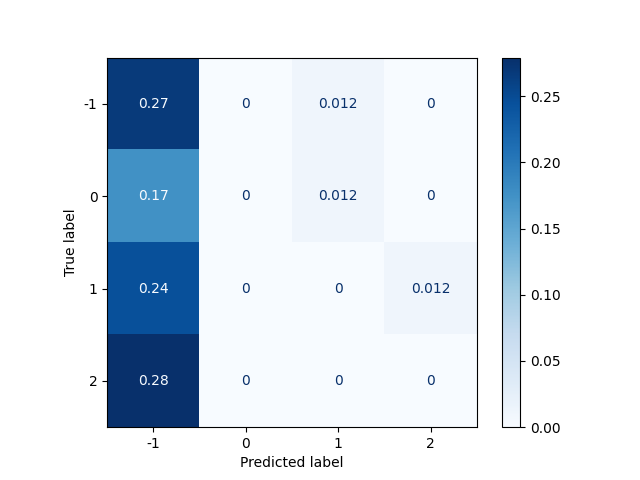

In [13]:
# Display HTML output artifacts
from IPython.display import display, HTML
display(HTML(mlrun.get_dataitem(train_run.outputs['confusion-matrix']).get().decode('utf-8')))


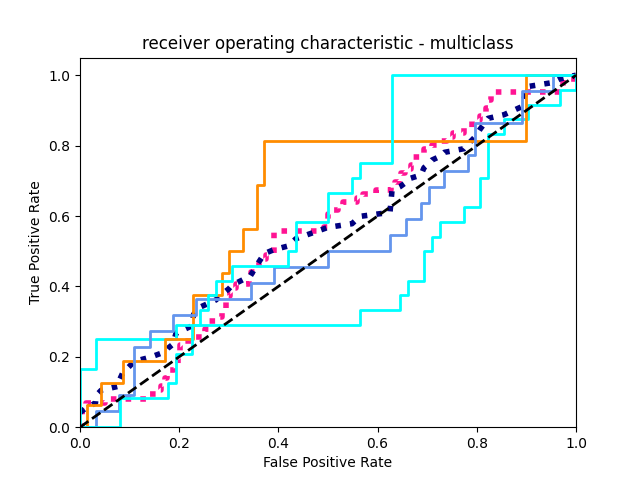

In [14]:
display(HTML(mlrun.get_dataitem(train_run.outputs['roc-multiclass']).get().decode('utf-8')))

<a id="gs-explore-data-w-pandas-df"></a>

## Step 4: Exploring the Data 

Extract information from data set and visually analyze it.

In [19]:
describe = mlrun.import_function('hub://describe').apply(auto_mount())
describe.spec.image = 'mlrun/mlrun'

In [21]:
# describe the function 
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    train_run.outputs['test_set']})

> 2021-07-06 21:11:52,876 [info] starting run describe-summarize uid=0e0ea4cf24d348ae8fed420595545ecc DB=http://mlrun-api:8080
> 2021-07-06 21:11:52,976 [info] Job is running in the background, pod: describe-summarize-49k6c
> 2021-07-06 21:12:20,580 [info] run executed, status=completed
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
Dataset has 0 variance; skipping density estimate.
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-jovyan,...95545ecc,0,Jul 06 21:11:59,completed,describe-summarize,kind=jobowner=jovyanhost=describe-summarize-49k6c,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 0e0ea4cf24d348ae8fed420595545ecc --project getting-started-tutorial-jovyan , !mlrun logs 0e0ea4cf24d348ae8fed420595545ecc --project getting-started-tutorial-jovyan
> 2021-07-06 21:12:22,249 [info] run executed, status=completed



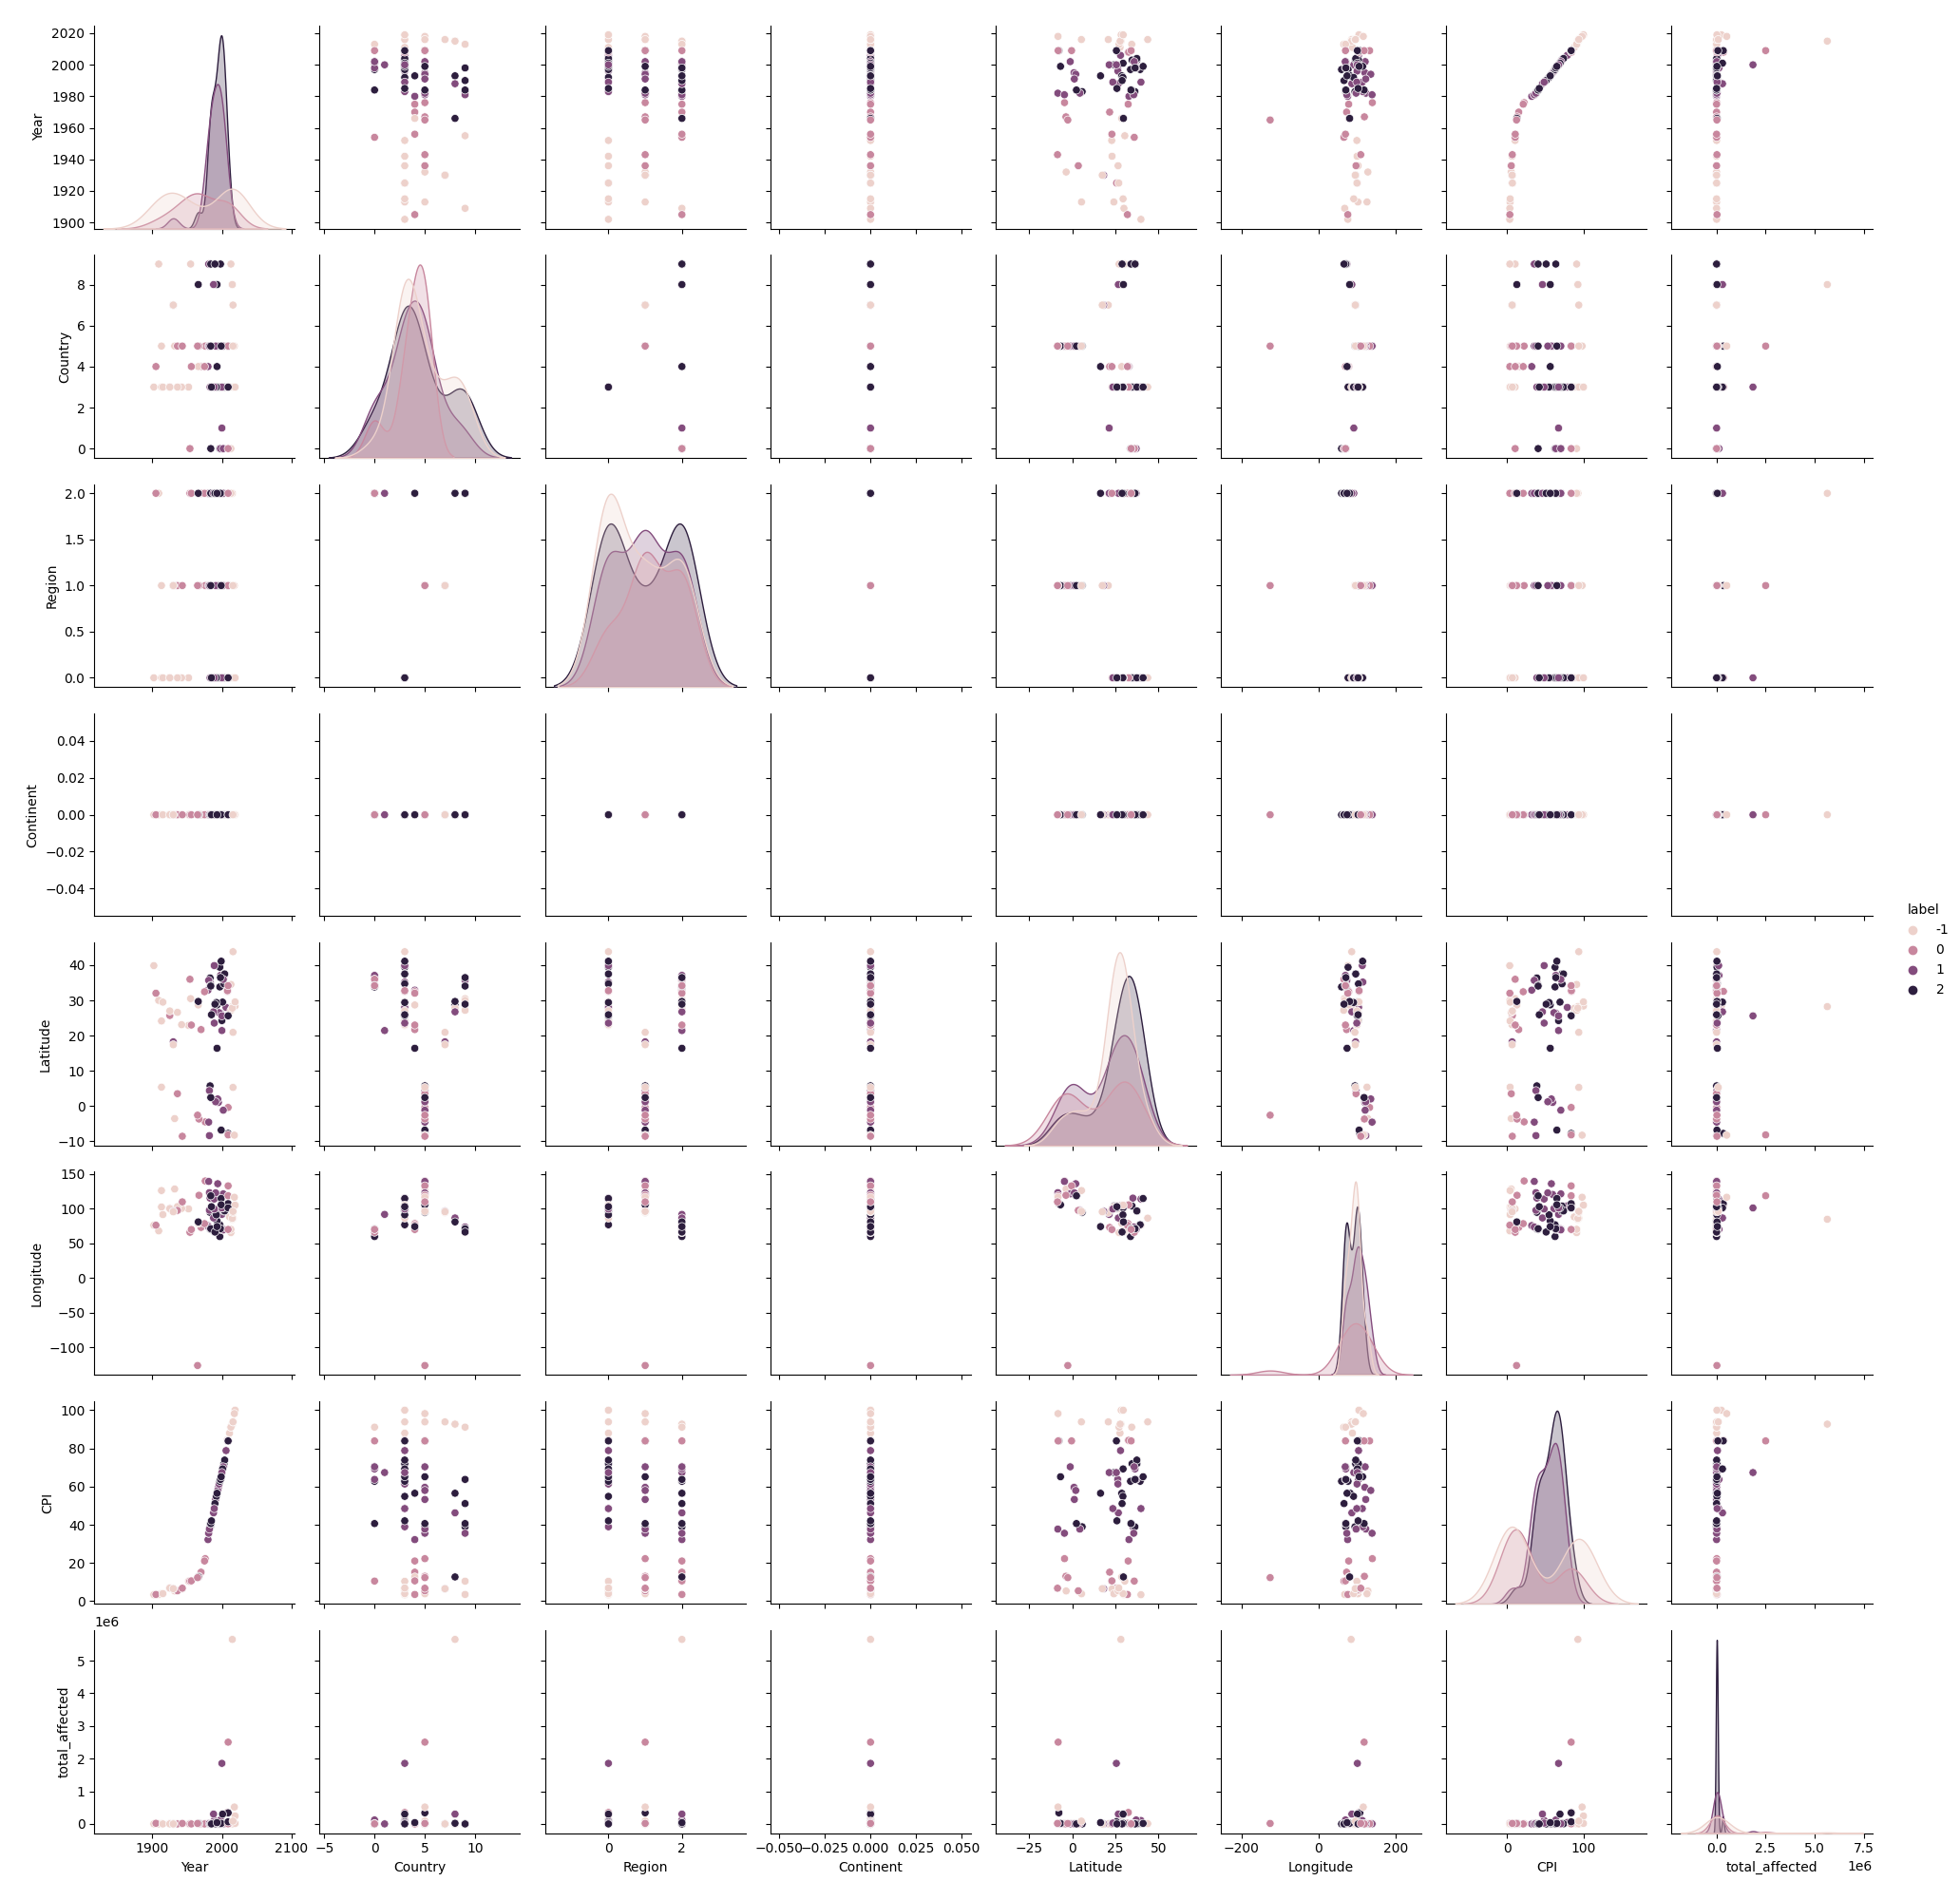

In [22]:
# Display the `histograms` artifact
display(HTML(mlrun.get_dataitem(describe_run.outputs['histograms']).get().decode('utf-8')))


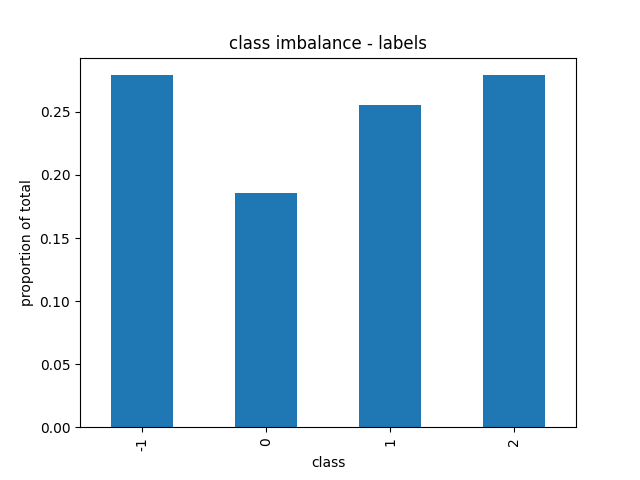

In [23]:
# Display the `imbalance` artifact
display(HTML(mlrun.get_dataitem(describe_run.outputs['imbalance']).get().decode('utf-8')))


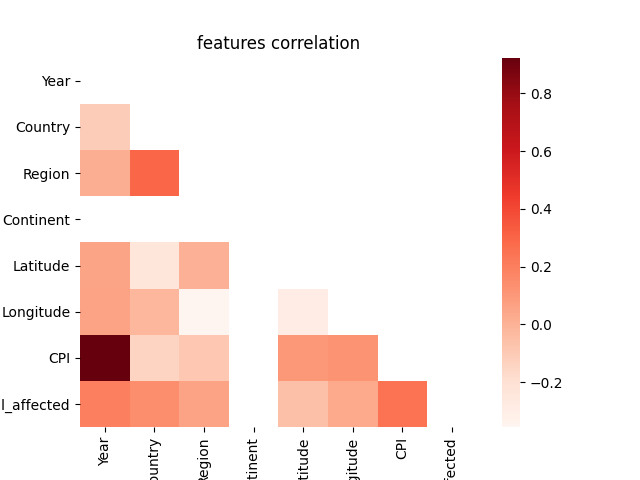

In [24]:
# Display the `correlation` artifact
display(HTML(mlrun.get_dataitem(describe_run.outputs['correlation']).get().decode('utf-8')))

<a id="gs-tutorial-2-step-test-model"></a>

## Step 5: Testing Your Model

Test the model by running the selected trained model against the test data set.

In [25]:
# adding a test function
test = mlrun.import_function('hub://test_classifier').apply(auto_mount())
test.spec.image = 'mlrun/mlrun'

In [26]:
test_run = test.run(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']})

> 2021-07-06 21:12:22,561 [info] starting run test uid=9dfa9c2398ea452291662901f3d95c56 DB=http://mlrun-api:8080
> 2021-07-06 21:12:22,679 [info] Job is running in the background, pod: test-b8jts
> 2021-07-06 21:12:30,314 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-jovyan,...f3d95c56,0,Jul 06 21:12:29,completed,test,kind=jobowner=jovyanhost=test-b8jts,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=0.26744186046511625test-error=0.7325581395348837auc-micro=0.555390301063638auc-weighted=0.5399930339727789f1-score=0.1074766355140187precision_score=0.06927710843373494recall_score=0.23958333333333334,confusion-matrixprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 9dfa9c2398ea452291662901f3d95c56 --project getting-started-tutorial-jovyan , !mlrun logs 9dfa9c2398ea452291662901f3d95c56 --project getting-started-tutorial-jovyan
> 2021-07-06 21:12:31,842 [info] run executed, status=completed


Test Accuracy: 0.26744186046511625



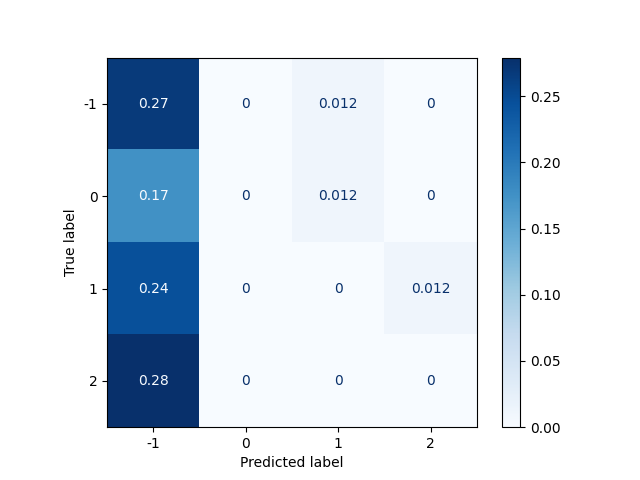


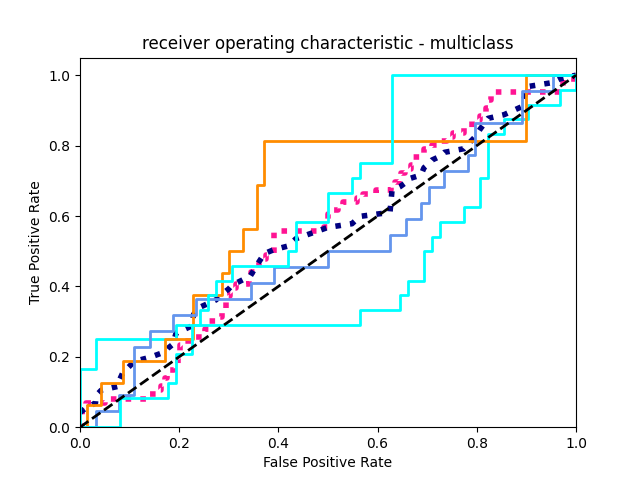

In [27]:
# Display the model accuracy
print(f'Test Accuracy: {test_run.outputs["accuracy"]}')

# Display HTML output artifacts
display(HTML(mlrun.get_dataitem(test_run.outputs['confusion-matrix']).get().decode('utf-8')))
display(HTML(mlrun.get_dataitem(test_run.outputs['roc-multiclass']).get().decode('utf-8')))